In [1]:
import tensorflow as tf
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
import numpy as np

# Configuration
IMG_WIDTH = 256
IMG_HEIGHT = 256
BUFFER_SIZE = 400
BATCH_SIZE = 1  # Original paper uses batch size 1
OUTPUT_CHANNELS = 3
LAMBDA = 100  # Weight for L1 loss

In [123]:
def load(noisy_path, clean_path):
    """Load a pair of noisy and clean images"""
    # Load noisy image
    noisy_image = tf.io.read_file(noisy_path)
    noisy_image = tf.io.decode_jpeg(noisy_image)
    noisy_image = tf.cast(noisy_image, tf.float32)
    
    # Load clean image
    clean_image = tf.io.read_file(clean_path)
    clean_image = tf.io.decode_jpeg(clean_image)
    clean_image = tf.cast(clean_image, tf.float32)
    
    return noisy_image, clean_image

def normalize(input_image, real_image):
    """Normalize images to [-1, 1]"""
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

def load_image_train(noisy_path, clean_path):
    """Load and preprocess training images"""
    noisy_image, clean_image = load(noisy_path, clean_path)
    #noisy_image, clean_image = resize(noisy_image, clean_image, 256, 256)
    noisy_image, clean_image = normalize(noisy_image, clean_image)
    return noisy_image, clean_image




In [124]:
# Create paired datasets from two separate directories
noisy_files = sorted(tf.io.gfile.glob('/Users/yousefshafik/Desktop/coen691/output/pairs/denoise/LR/*.png'))
clean_files = sorted(tf.io.gfile.glob('/Users/yousefshafik/Desktop/coen691/output/pairs/denoise/HR/*.png'))

# Make sure files are paired correctly (same order/names)
noisy_dataset = tf.data.Dataset.from_tensor_slices(noisy_files)
clean_dataset = tf.data.Dataset.from_tensor_slices(clean_files)

# Zip them together to create pairs
paired_dataset = tf.data.Dataset.zip((noisy_dataset, clean_dataset))


# Map the loading function
train_dataset = paired_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
#train_dataset = train_dataset.batch(1)

In [125]:
def downsample(filters, size, apply_batchnorm=True):
    """Encoder block: Conv -> BatchNorm -> LeakyReLU"""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    """Decoder block: ConvTranspose -> BatchNorm -> Dropout -> ReLU"""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    return result

def Generator():
    """U-Net based generator with skip connections"""
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    # Encoder (downsampling)
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),   # (bs, 64, 64, 128)
        downsample(256, 4),   # (bs, 32, 32, 256)
        downsample(512, 4),   # (bs, 16, 16, 512)
        downsample(512, 4),   # (bs, 8, 8, 512)
        downsample(512, 4),   # (bs, 4, 4, 512)
        downsample(512, 4),   # (bs, 2, 2, 512)
        downsample(512, 4),   # (bs, 1, 1, 512)
    ]
    
    # Decoder (upsampling)
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),   # (bs, 16, 16, 1024)
        upsample(256, 4),   # (bs, 32, 32, 512)
        upsample(128, 4),   # (bs, 64, 64, 256)
        upsample(64, 4),    # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (bs, 256, 256, 3)
    
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [126]:
def Discriminator():
    """PatchGAN discriminator"""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)
    
    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)     # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)     # (bs, 32, 32, 256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                   kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [127]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    """Generator loss: adversarial + L1"""
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # L1 loss
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    """Discriminator loss"""
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss


In [128]:
generator = Generator()
discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [129]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                           generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                           generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                               discriminator.trainable_variables))
    
    return gen_total_loss, disc_loss

def fit(train_ds, test_ds, steps):
    """Training loop"""
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            print(f"Step: {step//1000}k")
        
        gen_loss, disc_loss = train_step(input_image, target, step)
        
        # Save checkpoint every 5k steps
        if (step+1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


In [130]:
import math
test_size = math.ceil(len(train_dataset) * 0.2)
train_size = len(train_dataset) - test_size

In [131]:
len(train_dataset)

399

In [187]:
actual_train_dataset = train_dataset.take(train_size) 
actual_test_dataset = train_dataset.skip(train_size)

In [133]:
len(actual_train_dataset), len(actual_test_dataset)

(319, 80)

In [188]:
actual_train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None))>

In [135]:
# Load your data (adjust paths for your noisy/clean paired images)

actual_train_dataset = actual_train_dataset.shuffle(BUFFER_SIZE)
actual_train_dataset = actual_train_dataset.batch(BATCH_SIZE)


# Setup checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

# Train the model
EPOCHS = 200
STEPS_PER_EPOCH = 400  # Adjust based on your dataset size
fit(actual_train_dataset, actual_test_dataset, steps=EPOCHS * STEPS_PER_EPOCH)


Step: 0k
Step: 1k
Step: 2k
Step: 3k
Step: 4k
Step: 5k
Step: 6k
Step: 7k
Step: 8k
Step: 9k
Step: 10k
Step: 11k
Step: 12k
Step: 13k
Step: 14k
Step: 15k
Step: 16k
Step: 17k
Step: 18k
Step: 19k
Step: 20k
Step: 21k
Step: 22k
Step: 23k
Step: 24k
Step: 25k
Step: 26k
Step: 27k
Step: 28k
Step: 29k
Step: 30k
Step: 31k
Step: 32k
Step: 33k
Step: 34k
Step: 35k
Step: 36k
Step: 37k
Step: 38k
Step: 39k
Step: 40k
Step: 41k
Step: 42k
Step: 43k
Step: 44k
Step: 45k
Step: 46k
Step: 47k
Step: 48k
Step: 49k
Step: 50k
Step: 51k
Step: 52k
Step: 53k
Step: 54k
Step: 55k
Step: 56k
Step: 57k
Step: 58k
Step: 59k
Step: 60k
Step: 61k
Step: 62k
Step: 63k
Step: 64k
Step: 65k
Step: 66k
Step: 67k
Step: 68k
Step: 69k
Step: 70k
Step: 71k
Step: 72k
Step: 73k
Step: 74k
Step: 75k
Step: 76k
Step: 77k
Step: 78k
Step: 79k


In [174]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

# Recreate the models (same as training)
generator = Generator()
discriminator = Discriminator()

# Recreate optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Setup checkpoint
checkpoint_dir = './training_checkpoints'
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

# Load the latest checkpoint
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
if checkpoint_path:
    checkpoint.restore(checkpoint_path)
    print(f"Checkpoint restored from: {checkpoint_path}")
else:
    print("No checkpoint found!")


Checkpoint restored from: ./training_checkpoints/ckpt-16



Generating predictions on test set...


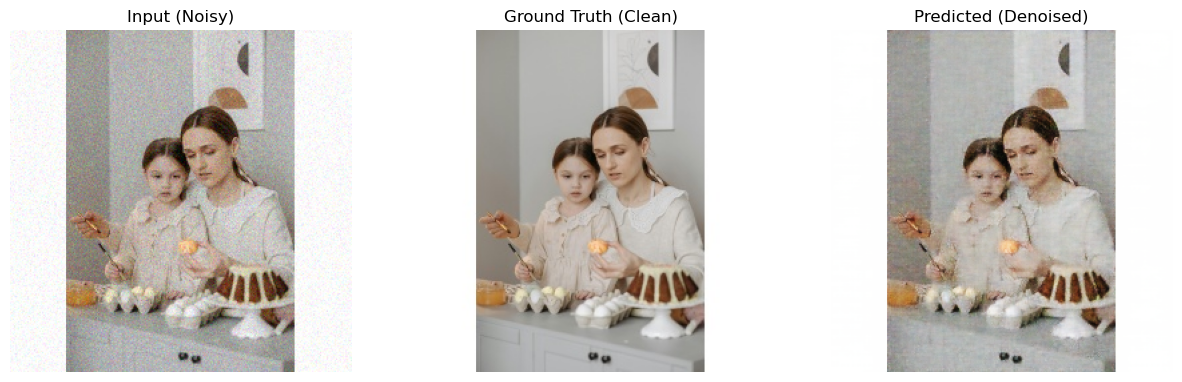

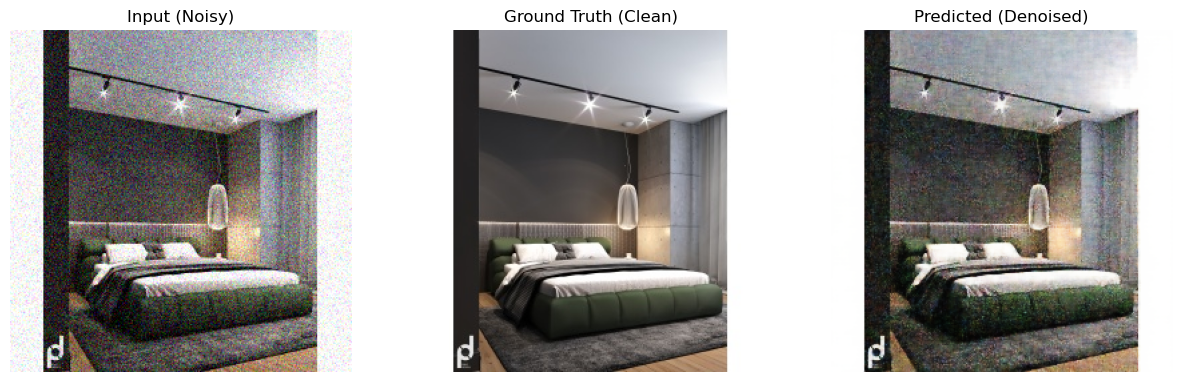

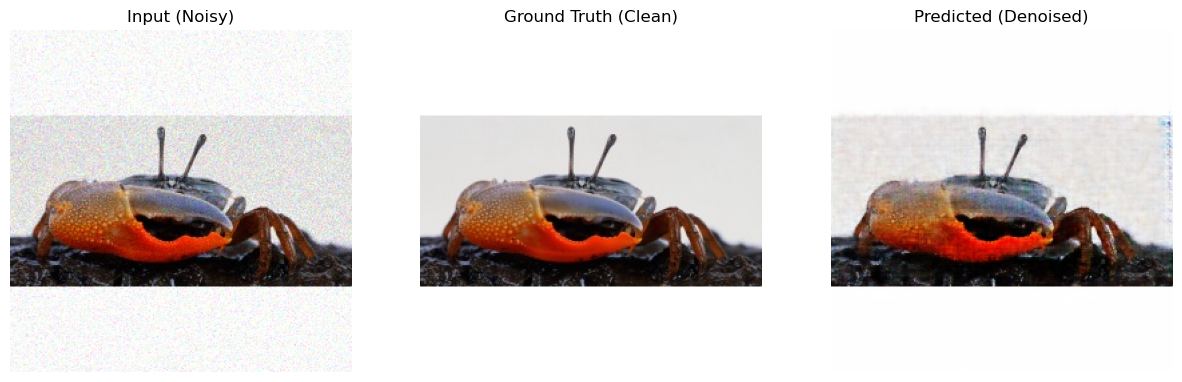

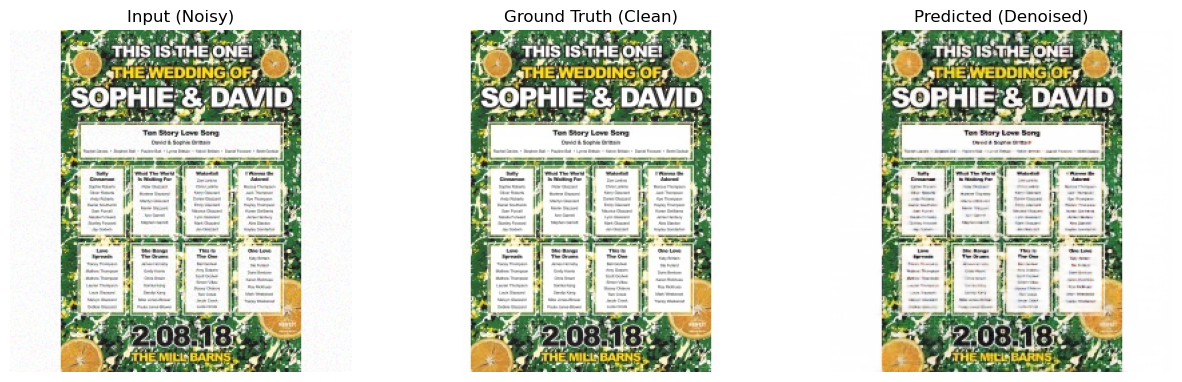

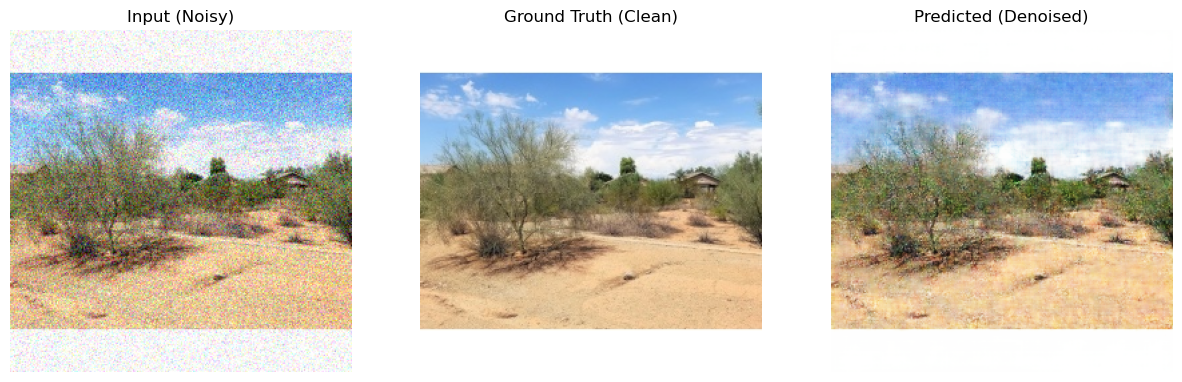

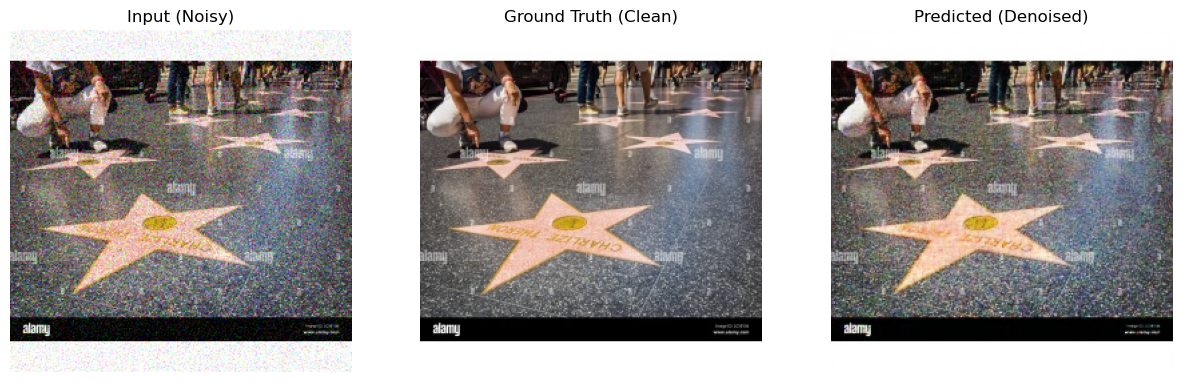

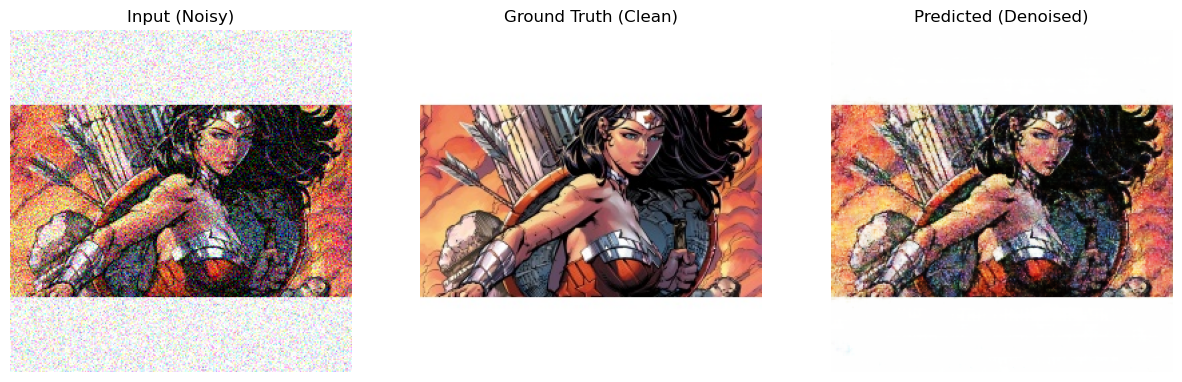

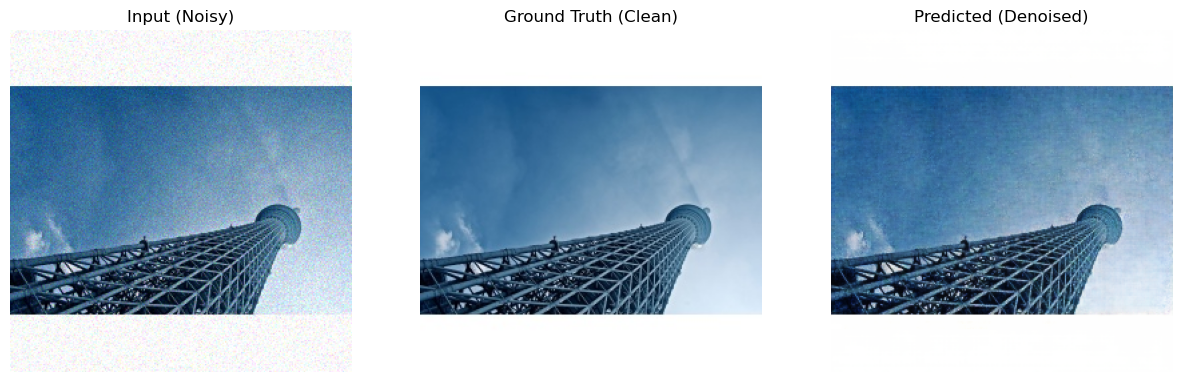

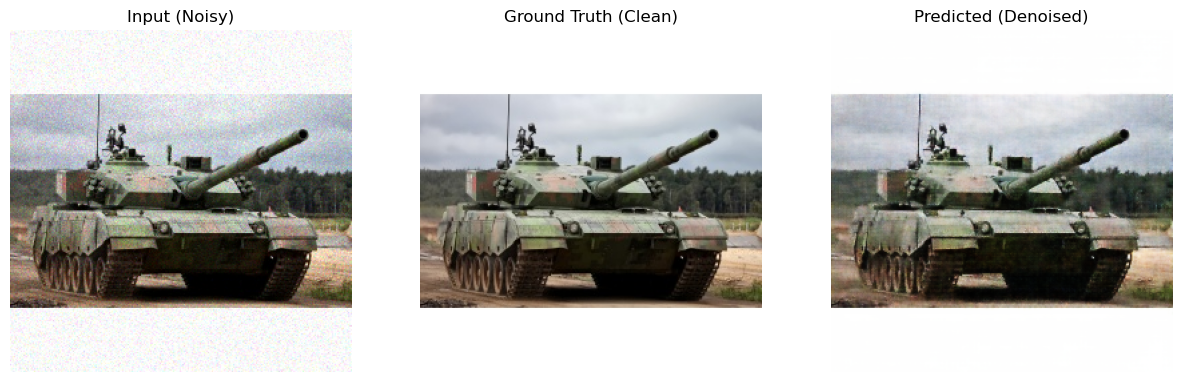

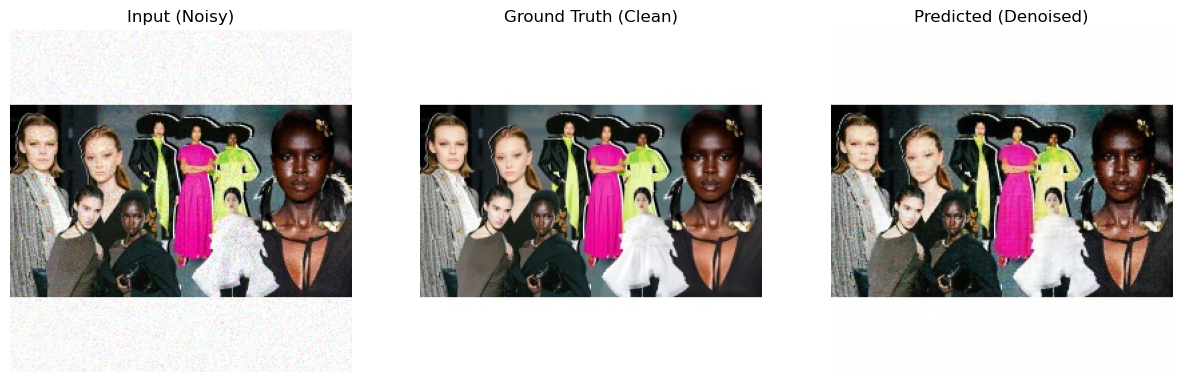

2025-11-20 11:31:10.064698: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [175]:
def generate_images(model, test_input, target, save_path=None):
    """Generate and display predictions"""
    prediction = model(test_input, training=True)  # Use training=True for batchnorm
    
    plt.figure(figsize=(15, 5))
    
    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input (Noisy)', 'Ground Truth (Clean)', 'Predicted (Denoised)']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Denormalize from [-1, 1] to [0, 1]
        img = display_list[i] * 0.5 + 0.5
        plt.imshow(img)
        plt.axis('off')
    
    #if save_path:
    #    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    #    print(f"Saved to {save_path}")
    plt.show()

# Test on a few examples from test set
print("\nGenerating predictions on test set...")
for i, (inp, tar) in enumerate(actual_test_dataset.take(10).batch(1)):
    generate_images(generator, inp, tar, 
                   save_path=f'./test_results/prediction_{i+1}.png')


In [176]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_metrics(model, test_dataset):
    """Calculate PSNR and SSIM metrics"""
    psnr_values = []
    ssim_values = []
    mae_values = []
    
    for inp, tar in test_dataset:
        # Generate prediction
        pred = model(inp, training=True)
        
        # Convert to numpy and denormalize
        target_np = (tar[0].numpy() * 0.5 + 0.5)
        pred_np = (pred[0].numpy() * 0.5 + 0.5)
        
        # Clip values to [0, 1]
        target_np = np.clip(target_np, 0, 1)
        pred_np = np.clip(pred_np, 0, 1)
        
        # Calculate PSNR
        psnr_val = psnr(target_np, pred_np, data_range=1.0)
        psnr_values.append(psnr_val)
        
        # Calculate SSIM
        ssim_val = ssim(target_np, pred_np, 
                       data_range=1.0, 
                       channel_axis=2)
        ssim_values.append(ssim_val)
        
        # Calculate MAE
        mae = np.mean(np.abs(target_np - pred_np))
        mae_values.append(mae)
    
    return {
        'PSNR': np.mean(psnr_values),
        'SSIM': np.mean(ssim_values),
        'MAE': np.mean(mae_values),
        'PSNR_std': np.std(psnr_values),
        'SSIM_std': np.std(ssim_values)
    }

# Calculate metrics
print("\nCalculating test metrics...")
metrics = calculate_metrics(generator, actual_test_dataset.batch(1))

print("\n=== Test Results ===")
print(f"PSNR: {metrics['PSNR']:.2f} ± {metrics['PSNR_std']:.2f} dB")
print(f"SSIM: {metrics['SSIM']:.4f} ± {metrics['SSIM_std']:.4f}")
print(f"MAE: {metrics['MAE']:.4f}")
print("====================")



Calculating test metrics...

=== Test Results ===
PSNR: 28.58 ± 3.94 dB
SSIM: 0.8420 ± 0.0991
MAE: 0.0273


In [177]:
generator.summary()

Model: "functional_215"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_190     │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_180      │ (None, 128, 128,  │      3,072 │ input_layer_190[… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_181      │ (None, 64, 64,    │    131,584 │ sequential_180[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_182      │ (None, 32, 32,    │    525,312 │ sequential_181[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_183      │ (None, 16, 16,    │  2,099,200 │ sequential_182[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_184      │ (None, 8, 8, 512) │  4,196,352 │ sequential_183[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_185      │ (None, 4, 4, 512) │  4,196,352 │ sequential_184[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_186      │ (None, 2, 2, 512) │  4,196,352 │ sequential_185[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_187      │ (None, 1, 1, 512) │  4,196,352 │ sequential_186[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_188      │ (None, 2, 2, 512) │  4,196,352 │ sequential_187[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_80      │ (None, 2, 2,      │          0 │ sequential_188[0… │
│ (Concatenate)       │ 1024)             │            │ sequential_186[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_189      │ (None, 4, 4, 512) │  8,390,656 │ concatenate_80[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_81      │ (None, 4, 4,      │          0 │ sequential_189[0… │
│ (Concatenate)       │ 1024)             │            │ sequential_185[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_190      │ (None, 8, 8, 512) │  8,390,656 │ concatenate_81[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_82      │ (None, 8, 8,      │          0 │ sequential_190[0… │
│ (Concatenate)       │ 1024)             │            │ sequential_184[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_191      │ (None, 16, 16,    │  8,390,656 │ concatenate_82[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_83      │ (None, 16, 16,    │          0 │ sequential_191[0

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [179]:
discriminator.summary()

Model: "functional_219"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_87      │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_195      │ (None, 128, 128,  │      6,144 │ concatenate_87[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_196      │ (None, 64, 64,    │    131,584 │ sequential_195[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_197      │ (None, 32, 32,    │    525,312 │ sequential_196[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_20   │ (None, 34, 34,    │          0 │ sequential_197[0… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_141 (Conv2D) │ (None, 31, 31,    │  2,097,152 │ zero_padding2d_2… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_141[0][0]  │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_131     │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_21   │ (None, 33, 33,    │          0 │ leaky_re_lu_131[… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_142 (Conv2D) │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_2… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

ValueError: Attempt to convert a value (<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, None, None), dtype=tf.float32, name=None))>) with an unsupported type (<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>) to a Tensor.

Restored from ./training_checkpoints/ckpt-16, resuming at epoch 16
Epoch 17/30


Gen Loss: 6.2117 | Disc Loss: 0.9485 | L1 Loss: 0.0423 | PSNR: 20.24
Time for epoch 17 is 244.91 sec
Epoch 18/30
Gen Loss: 6.1178 | Disc Loss: 0.9489 | L1 Loss: 0.0421 | PSNR: 20.63
Time for epoch 18 is 242.97 sec
Epoch 19/30
Gen Loss: 6.2703 | Disc Loss: 0.7969 | L1 Loss: 0.0424 | PSNR: 18.61
Time for epoch 19 is 238.90 sec
Epoch 20/30
Gen Loss: 6.5446 | Disc Loss: 0.7638 | L1 Loss: 0.0428 | PSNR: 19.16
Time for epoch 20 is 251.69 sec
Checkpoint saved at ./training_checkpoints/ckpt-20-17
Epoch 21/30
Gen Loss: 6.5891 | Disc Loss: 0.7858 | L1 Loss: 0.0427 | PSNR: 20.20
Time for epoch 21 is 278.68 sec
Epoch 22/30
Gen Loss: 6.4503 | Disc Loss: 0.8375 | L1 Loss: 0.0425 | PSNR: 19.66
Time for epoch 22 is 284.82 sec
Epoch 23/30
Gen Loss: 6.0005 | Disc Loss: 1.0775 | L1 Loss: 0.0419 | PSNR: 19.21
Time for epoch 23 is 252.50 sec
Epoch 24/30
Gen Loss: 6.2029 | Disc Loss: 0.8254 | L1 Loss: 0.0420 | PSNR: 18.67
Time for epoch 24 is 252.72 sec
Epoch 25/30
Gen Loss: 6.2082 | Disc Loss: 0.8991 | L1 

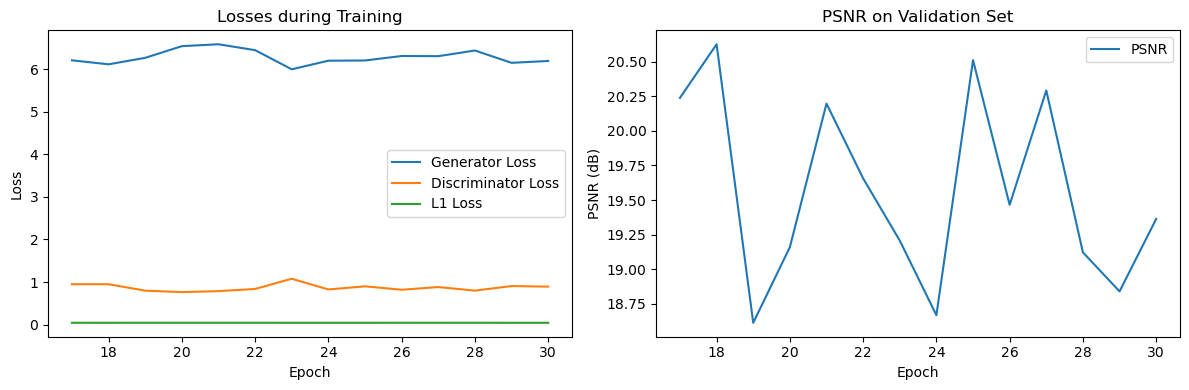

In [189]:
import tensorflow as tf
import numpy as np
import time
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

# Assume your generator, discriminator, optimizers are defined:
# generator, discriminator, generator_optimizer, discriminator_optimizer

# Setup checkpoint manager
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = f"{checkpoint_dir}/ckpt"
checkpoint = tf.train.Checkpoint(generator=generator,
                                 discriminator=discriminator,
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer)

latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
start_epoch = 0
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    # Optional: read start_epoch from checkpoint name, e.g. 'ckpt-42'
    import re
    match = re.search(r'ckpt-(\d+)', latest_checkpoint)
    if match:
        start_epoch = int(match.group(1))
    print(f"Restored from {latest_checkpoint}, resuming at epoch {start_epoch}")

# Loss function and training step (your definitions may vary)
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (LAMBDA * l1_loss), l1_loss

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return gen_total_loss, disc_loss, l1_loss

def calculate_psnr(model, dataset):
    psnr_values = []
    for inp, tar in dataset:
        pred = model(inp, training=False)
        # Convert normalized [-1,1] back to [0,1]
        pred_img = (pred[0].numpy() * 0.5) + 0.5
        tar_img = (tar[0].numpy() * 0.5) + 0.5
        # Clip values to [0,1]
        pred_img = np.clip(pred_img, 0, 1)
        tar_img = np.clip(tar_img, 0, 1)
        psnr_val = compare_psnr(tar_img, pred_img, data_range=1.0)
        psnr_values.append(psnr_val)
    return np.mean(psnr_values)

# Lists to log loss and PSNR history
gen_loss_history = []
disc_loss_history = []
l1_loss_history = []
psnr_history = []

# Training loop with history recording
EPOCHS = 30
actual_train_dataset = actual_train_dataset.shuffle(400).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
actual_test_dataset = actual_test_dataset.batch(1).prefetch(tf.data.AUTOTUNE)

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    epoch_gen_loss = []
    epoch_disc_loss = []
    epoch_l1_loss = []
    
    for input_image, target in actual_train_dataset:
        gen_loss, disc_loss, l1_loss = train_step(input_image, target)
        epoch_gen_loss.append(gen_loss.numpy())
        epoch_disc_loss.append(disc_loss.numpy())
        epoch_l1_loss.append(l1_loss.numpy())
    
    avg_gen_loss = np.mean(epoch_gen_loss)
    avg_disc_loss = np.mean(epoch_disc_loss)
    avg_l1_loss = np.mean(epoch_l1_loss)
    
    # Calculate PSNR on test set at the end of this epoch
    avg_psnr = calculate_psnr(generator, actual_test_dataset)
    
    print(f"Gen Loss: {avg_gen_loss:.4f} | Disc Loss: {avg_disc_loss:.4f} | L1 Loss: {avg_l1_loss:.4f} | PSNR: {avg_psnr:.2f}")
    print(f"Time for epoch {epoch + 1} is {time.time() - start:.2f} sec")
    
    gen_loss_history.append(avg_gen_loss)
    disc_loss_history.append(avg_disc_loss)
    l1_loss_history.append(avg_l1_loss)
    psnr_history.append(avg_psnr)
    
    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        save_path = checkpoint.save(file_prefix=checkpoint_prefix+f"-{epoch+1}")
        print(f"Checkpoint saved at {save_path}")

# After training, you can plot losses and PSNR:

import matplotlib.pyplot as plt

epochs_range = range(start_epoch + 1, EPOCHS + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, gen_loss_history, label='Generator Loss')
plt.plot(epochs_range, disc_loss_history, label='Discriminator Loss')
plt.plot(epochs_range, l1_loss_history, label='L1 Loss')
plt.legend()
plt.title('Losses during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(epochs_range, psnr_history, label='PSNR')
plt.legend()
plt.title('PSNR on Validation Set')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')

plt.tight_layout()
plt.show()


In [185]:
actual_test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, None, None, None), dtype=tf.float32, name=None))>